# Classification with Quantum Computing and Deep Neural Networks

In this notebook, we explore multiclass classification using Qiskit Machine Learning integrated with PyTorch. Unlike many tutorials that focus on binary classification in quantum computing, our approach extends to multiclass classification, providing a more realistic model for complex, real-world scenarios. We enhance our exploration by experimenting with hybrid models—combining Quantum Neural Networks (QNNs) and Deep Neural Networks (DNNs)—to achieve robust and potentially more accurate classification results.

The dataset used is the well-known Iris flower dataset, frequently employed in machine learning for its straightforward yet effective demonstration capabilities. While not overly complex, this dataset serves as a suitable foundation for illustrating the power of quantum and hybrid approaches.

The notebook is divided into three main sections:


- Section 1: Introduction to Classification with Qiskit Machine Learning <br>
    Here, we provide a brief guide to the Qiskit Machine Learning library. We implement a Variational Quantum Classifier (VQC) alongside a classical Support Vector Machine (SVM) as a baseline for performance comparison.
- Section 2: Advanced Hybrid Modeling with QNNs <br>
 This section dives into two of Qiskit Machine Learning’s primary modules—EstimatorQNN and SamplerQNN. We use each to construct fully quantum classifiers as well as hybrid models, demonstrating both the pure quantum approach and the benefits of hybrid quantum-classical systems.
- Section 3: Results and Analysis <br>
    In this section, we compare the performance of different models used for multiclass classification.

In [1]:
#Import required packages
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, f1_score
from qiskit.circuit.library import ZZFeatureMap,PauliFeatureMap
from qiskit.circuit.library import RealAmplitudes
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.primitives import StatevectorSampler
from IPython.display import clear_output
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit
import torch

from torch.optim import LBFGS, Adam
from torch.nn import Linear


## Section 1: Introduction to Classification with Qiskit Machine Learning

Classification is a fundamental task in Machine Learning (ML), with a wide range of applications. Many introductory ML tutorial start with the Iris dataset, a classic choice fo its multivariate, multivariate structure, making it ideal for foundational learning. <br>
In the context of Quantum Computing (QC), many tutorials remain focused on simpler, binary problems du to the current limitation of QC technology. Here, out aim is to bridge this gap by applying quantum techniques to more realistic, multiclass problems. <br>
To establish a performance baseline, we first implement a classical Support Vector Machine (SVM) for the classification task. Then, we extend this approach to the quantum realm by performing the same task with Qiskit's Variational Quantum Classifier (VQC), offering a direct comparison between classical and quantum models.

This section is based heavily on the Qiskit basic tutorial

In [2]:
#Import data
data = load_iris()

df_features = pd.DataFrame(data.data, columns=data.feature_names)
df_target = pd.DataFrame(data.target)

df_features.head(5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


We normalize the data

In [3]:
train_X, test_X, train_y, test_y = train_test_split(
    data.data, data.target, train_size=0.8, shuffle=True )

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(train_X)
X_test_scaled = scaler.transform(test_X)

##### 1.1 Classical clasification with SVM

In [4]:
#Train and test SvM
svc = SVC()
_ = svc.fit(X_train_scaled, train_y) 

train_pred = svc.predict(X_train_scaled)
test_pred = svc.predict(X_test_scaled)


print('Results SVM')
print(f'accuracy train: { accuracy_score(train_pred, train_y):.4f}')
print(f'f1 score train: { f1_score(train_pred, train_y, average='weighted'):.4f}')

print(f'accuracy test: { accuracy_score(test_pred, test_y):.4f}')
print(f'f1 score test: { f1_score(test_pred, test_y, average='weighted'):.4f}')


Results SVM
accuracy train: 0.9833
f1 score train: 0.9833
accuracy test: 0.9667
f1 score test: 0.9664


#### 1.2  Variational Quantum Classifier (VQC) using Sampler

In [5]:
num_features = train_X.shape[1] #num features
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
#feature_map.decompose().draw(output="mpl", style="clifford") 
ansatz = RealAmplitudes(num_qubits=num_features, reps=1) #ansatz

optimizer = L_BFGS_B()
sampler = StatevectorSampler()

In [6]:
#Function to graph performance
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    return objective_func_vals

In [7]:

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []
start = time.time()
vqc.fit(X_train_scaled, train_y)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


Training time: 97 seconds


In [8]:
train_pred = vqc.predict(X_train_scaled)
test_pred = vqc.predict(X_test_scaled)

print('Results VQC')
print(f'accuracy train: { accuracy_score(train_pred, train_y):.4f}')
print(f'f1 score train: { f1_score(train_pred, train_y, average='weighted'):.4f}')

print(f'accuracy test: { accuracy_score(test_pred, test_y):.4f}')
print(f'f1 score test: { f1_score(test_pred, test_y, average='weighted'):.4f}')


Results VQC
accuracy train: 0.5667
f1 score train: 0.6871
accuracy test: 0.5000
f1 score test: 0.5778


## Section 2: Advanced Hybrid Modeling with QNNs 
In this section, we explore advanced classification techniques using two core modeules from Qiskit Machine Learning: SamplerQNN and EstimatorQNN. Using each module, we develop both fully quantum models and hybrid models that integrate classical neural network layers. This approach allows us to leverage the strengths of both quantum and classical computing, aiming to enhance model performance and robustness for the classification task.

In [9]:
#Convert data in tensor
X_tensor_train_scaled = torch.Tensor(X_train_scaled)
y_tensor_train = (torch.Tensor(train_y)).to(torch.int64)
X_tensor_test_scaled = torch.Tensor(X_test_scaled)
y_tensor_test = (torch.Tensor(test_y)).to(torch.int64)
num_features = train_X.shape[1]


In [10]:
#Define the EstimatorQNN
def create_estimator_qnn(feature_map, num_features):

    #feature_map.decompose().draw(output="mpl", style="clifford")
    ansatz = RealAmplitudes(num_qubits=num_features)

    qc = QuantumCircuit(num_features)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    #qc.draw(output="mpl", style="clifford")
    qnn_estimator = EstimatorQNN(
            circuit=qc, 
            input_params=feature_map.parameters,
            weight_params=ansatz.parameters,
            input_gradients=True,
            
            )

    return qnn_estimator

#### 2.1  EstimatorQNN

Since this is a multiclass problem and EstimatorQNN returns only a single output value, we create a separate EstimatorQNN for each class. The output values are then combined and passed through a Softmax function to produce the final class probabilities.

In [11]:
#Quantum Classifier using only QNN
class QuantumClassifier(torch.nn.Module):
    def __init__(self, qnn_class_0, qnn_class_1, qnn_class_2):
        super(QuantumClassifier, self).__init__()
        # Attach the QNN to Torch via TorchConnector
        self.qnn_0 = TorchConnector(qnn_class_0)
        self.qnn_1 = TorchConnector(qnn_class_1)
        self.qnn_2 = TorchConnector(qnn_class_2)


    def forward(self, x):
        # Get output for each class QNN
        output_0 = self.qnn_0(x)
        output_1 = self.qnn_1(x)
        output_2 = self.qnn_2(x)

        quantum_output = torch.cat([output_0, output_1, output_2], dim=-1)

        # Softmax for n-class classification output
        return torch.nn.functional.softmax(quantum_output, dim=-1)

# We create one qnn for each class and we create different feature mapping
feature_map_0 = ZZFeatureMap(feature_dimension=num_features, reps=1, parameter_prefix='θ0')
feature_map_1 = PauliFeatureMap(feature_dimension=num_features, reps=1, parameter_prefix='θ1', paulis=["Z", "YY"])
feature_map_2 = PauliFeatureMap(feature_dimension=num_features, reps=1, parameter_prefix='θ2', paulis=["Z", "XX"])

model_qnn_0 = create_estimator_qnn(feature_map_0, num_features)
model_qnn_1 = create_estimator_qnn(feature_map_1, num_features)
model_qnn_2 = create_estimator_qnn(feature_map_2, num_features)
model_estimator_qnn = QuantumClassifier(model_qnn_0, model_qnn_1, model_qnn_2)

total_qnn_params = (model_qnn_0.num_weights + model_qnn_1.num_weights + model_qnn_2.num_weights)
total_params = sum(p.numel() for p in model_estimator_qnn.parameters())

print(f"Total QNN Parameters: {total_qnn_params}")
print(f"Total Parameters: {total_params}")


Total QNN Parameters: 48
Total Parameters: 48


/tmp/ipykernel_58584/1425307799.py:11: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn_estimator = EstimatorQNN(


In [12]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = Adam(model_estimator_qnn.parameters(), lr=0.1)

# Training loop
num_epochs = 100
loss_train_estimator = []
metrics = {'acc_train_estimator':[],
           'acc_test_estimator':[]}
for epoch in range(num_epochs):
    model_estimator_qnn.train()
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model_estimator_qnn(X_tensor_train_scaled)
    loss = loss_function(outputs, y_tensor_train)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    loss_train_estimator.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

    model_estimator_qnn.eval()
    output_train = model_estimator_qnn(X_tensor_train_scaled)
    train_pred = torch.argmax(output_train, dim=1)
    metrics['acc_train_estimator'].append(accuracy_score(train_pred, train_y))

    output_test = model_estimator_qnn(X_tensor_test_scaled)
    test_pred = torch.argmax(output_test, dim=1)
    metrics['acc_test_estimator'].append(accuracy_score(test_pred, test_y))


Epoch 0: Loss = 1.10721755027771
Epoch 10: Loss = 0.9831417202949524
Epoch 20: Loss = 0.966661274433136
Epoch 30: Loss = 0.9567421078681946
Epoch 40: Loss = 0.95396488904953
Epoch 50: Loss = 0.9509469270706177
Epoch 60: Loss = 0.9492893815040588
Epoch 70: Loss = 0.9482223987579346
Epoch 80: Loss = 0.9476493000984192
Epoch 90: Loss = 0.947311520576477


In [13]:
#Evaluate the model
model_estimator_qnn.eval()

output_train = model_estimator_qnn(X_tensor_train_scaled)
train_pred = torch.argmax(output_train, dim=1)

output_test = model_estimator_qnn(X_tensor_test_scaled)
test_pred = torch.argmax(output_test, dim=1)


metrics_estimator = {'accuracy_train': accuracy_score(train_pred, train_y),
                          'accuracy_test': accuracy_score(test_pred, test_y),
                          'f1_score_train': f1_score(train_pred, train_y, average='weighted'),
                          'f1_score_test': f1_score(test_pred, test_y, average='weighted'),
                          }

print('EstimatorQNN')

print(f'Accuracy train: { metrics_estimator['accuracy_train']:.4f}')
print(f'F1 score train: { metrics_estimator['f1_score_train']:.4f}')

print(f'Accuracy test: { metrics_estimator['accuracy_test']:.4f}')
print(f'F1 score test: { metrics_estimator['f1_score_test']:.4f}')

EstimatorQNN
Accuracy train: 0.8583
F1 score train: 0.8612
Accuracy test: 0.7000
F1 score test: 0.7120


#### 2.2  EstimatorQNN + Classical Neural Network

This model combines the EstimatorQNN with classical neural network layers. Similar to the previous model, we use a separate EstimatorQNN for each class. However, in this version, we add ReLU layers after concatenating the QNN outputs, followed by a final Softmax layer to produce the class probabilities.

In [14]:
#Define the EstimatorQNN
def create_estimator_qnn(feature_map, num_features):

    #feature_map.decompose().draw(output="mpl", style="clifford")
    ansatz = RealAmplitudes(num_qubits=num_features)

    qc = QuantumCircuit(num_features)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    #qc.draw(output="mpl", style="clifford")
    qnn_estimator = EstimatorQNN(
            circuit=qc, 
            input_params=feature_map.parameters,
            weight_params=ansatz.parameters,
            input_gradients=True,
            
            )

    return qnn_estimator

# Quantum Classifier using QNN +DNN
class QuantumClassifier_Multilayer(torch.nn.Module):
    def __init__(self, qnn_class_0, qnn_class_1, qnn_class_2, num_features):
        super(QuantumClassifier_Multilayer, self).__init__()
        # Attach the QNN to Torch via TorchConnector

        
        self.qnn_0 = TorchConnector(qnn_class_0)
        self.qnn_1 = TorchConnector(qnn_class_1)
        self.qnn_2 = TorchConnector(qnn_class_2)
        
        self.fc1 = Linear(num_features, 16)  
        self.fc2 = Linear(16, num_features)
        self.fc3 = Linear(3, 3) #3 num clases


    def forward(self, x):

        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))

        # Get output for each class QNN
        output_0 = self.qnn_0(x)
        output_1 = self.qnn_1(x)
        output_2 = self.qnn_2(x)

        quantum_output = torch.cat([output_0, output_1, output_2], dim=-1)

        x = self.fc3(quantum_output)  
    
        # Softmax for n-class classification output
        return torch.nn.functional.softmax(x, dim=-1)

# We create one qnn for each class and we create different feature mapping

feature_map_0 = ZZFeatureMap(feature_dimension=num_features, reps=1, parameter_prefix='θ0')
feature_map_1 = PauliFeatureMap(feature_dimension=num_features, reps=1, parameter_prefix='θ1', paulis=["Z", "YY"])
feature_map_2 = PauliFeatureMap(feature_dimension=num_features, reps=1, parameter_prefix='θ2', paulis=["Z", "XX"])

model_qnn_0 = create_estimator_qnn(feature_map_0, num_features)
model_qnn_1 = create_estimator_qnn(feature_map_1, num_features)
model_qnn_2 = create_estimator_qnn(feature_map_2, num_features)
model_estimator_hybrid = QuantumClassifier_Multilayer(model_qnn_0, model_qnn_1, model_qnn_2, num_features)


total_qnn_params = (model_qnn_0.num_weights + model_qnn_1.num_weights + model_qnn_2.num_weights)
total_params = sum(p.numel() for p in model_estimator_hybrid.parameters())

print(f"Total QNN Parameters: {total_qnn_params}")
print(f"Total Parameters: {total_params}")


Total QNN Parameters: 48
Total Parameters: 208


/tmp/ipykernel_58584/3892588629.py:11: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn_estimator = EstimatorQNN(


In [15]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = Adam(model_estimator_hybrid.parameters(), lr=0.1)

# Training loop
num_epochs = 100
loss_train_estimator_hybrid = [] 
metrics['acc_train_estimator_hybrid'] = []
metrics['acc_test_estimator_hybrid'] = []
for epoch in range(num_epochs):
    model_estimator_hybrid.train()
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model_estimator_hybrid(X_tensor_train_scaled)
    loss = loss_function(outputs, y_tensor_train)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    loss_train_estimator_hybrid.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

    model_estimator_hybrid.eval()
    output_train = model_estimator_hybrid(X_tensor_train_scaled)
    train_pred = torch.argmax(output_train, dim=1)
    metrics['acc_train_estimator_hybrid'].append(accuracy_score(train_pred, train_y))

    output_test = model_estimator_hybrid(X_tensor_test_scaled)
    test_pred = torch.argmax(output_test, dim=1)
    metrics['acc_test_estimator_hybrid'].append(accuracy_score(test_pred, test_y))


Epoch 0: Loss = 1.1072694063186646
Epoch 10: Loss = 1.014457106590271
Epoch 20: Loss = 0.8295822739601135
Epoch 30: Loss = 0.7522464394569397
Epoch 40: Loss = 0.680919885635376
Epoch 50: Loss = 0.6159346103668213
Epoch 60: Loss = 0.5896609425544739
Epoch 70: Loss = 0.580964982509613
Epoch 80: Loss = 0.576778769493103
Epoch 90: Loss = 0.5740591883659363


In [16]:
#Evaluate the model
model_estimator_hybrid.eval()
output_train = model_estimator_hybrid(X_tensor_train_scaled)
train_pred = torch.argmax(output_train, dim=1)

output_test = model_estimator_hybrid(X_tensor_test_scaled)
test_pred = torch.argmax(output_test, dim=1)


metrics_estimator_hybrid = {'accuracy_train': accuracy_score(train_pred, train_y),
                          'accuracy_test': accuracy_score(test_pred, test_y),
                          'f1_score_train': f1_score(train_pred, train_y, average='weighted'),
                          'f1_score_test': f1_score(test_pred, test_y, average='weighted'),
                          }

print('EstimatorQNN + DNN')
print(f'Accuracy train: { metrics_estimator_hybrid['accuracy_train']:.4f}')
print(f'F1 score train: { metrics_estimator_hybrid['f1_score_train']:.4f}')
print(f'Accuracy test: { metrics_estimator_hybrid['accuracy_test']:.4f}')
print(f'F1 score test: { metrics_estimator_hybrid['f1_score_test']:.4f}')

EstimatorQNN + DNN
Accuracy train: 0.9917
F1 score train: 0.9917
Accuracy test: 0.9333
F1 score test: 0.9327


#### 2.3  Sampler QNN

In this section, we use the SamplerQNN for classification. The SamplerQNN provides a probability distribution over possible outcomes, making it well-suited for multiclass tasks. Since our classification requires three distinct classes, we map the output bitstrings (representing the different possible outcomes) directly to our target classes. This approach leverages the probabilistic nature of SamplerQNN to capture class distributions, enhancing the model's ability to handle multiclass classification effectively.

In [17]:

num_features = train_X.shape[1]
num_classes = len(data.target_names)

def interpret_bitstring(bitstring):
    # Convert integer to binary if necessary, ensuring a list of bits for consistency
    if isinstance(bitstring, int):
        # Convert to binary and fill up to the number of qubits
        bitstring = [int(d) for d in f"{bitstring:0{num_features}b}"]
    # Sum bit values to get the class (mod num_classes to stay within range)
    return sum(bitstring) % num_classes


def create_sampler_qnn():

    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
    ansatz = RealAmplitudes(num_qubits=num_features)

    qc = QuantumCircuit(num_features)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    sampler = StatevectorSampler()
    qnn_sampler = SamplerQNN(
    circuit=qc,
    sampler=sampler,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=interpret_bitstring,
    input_gradients=True,
    output_shape=num_classes,
    )
    
    return qnn_sampler


class QuantumClassifier(torch.nn.Module):
    def __init__(self, qnn, num_classes=3):
        super(QuantumClassifier, self).__init__()
        # Attach the QNN to Torch via TorchConnector
        self.qnn = TorchConnector(qnn)
        self.num_classes = num_classes

    def forward(self, x):
        # Get probabilities from the QNN and select top `num_classes`
        quantum_output = self.qnn(x)
        return  torch.nn.functional.softmax(quantum_output, dim=-1)



model_qnn = create_sampler_qnn()
model_sampler_qnn = QuantumClassifier(qnn=model_qnn)

total_qnn_params = model_qnn.num_weights
total_params = sum(p.numel() for p in model_sampler_qnn.parameters())

print(f"Total QNN Parameters: {total_qnn_params}")
print(f"Total Parameters: {total_params}")

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


Total QNN Parameters: 16
Total Parameters: 16


In [18]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = Adam(model_sampler_qnn.parameters(), lr=0.1)


# Training loop
num_epochs = 100
loss_train_sampler = [] 
metrics['acc_train_sampler'], metrics['acc_test_sampler'] = [], []

for epoch in range(num_epochs):
    model_sampler_qnn.train()
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model_sampler_qnn(X_tensor_train_scaled)
    loss = loss_function(outputs, y_tensor_train)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    loss_train_sampler.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

    model_sampler_qnn.eval()
    output_train = model_sampler_qnn(X_tensor_train_scaled)
    train_pred = torch.argmax(output_train, dim=1)
    metrics['acc_train_sampler'].append(accuracy_score(train_pred, train_y))

    output_test = model_sampler_qnn(X_tensor_test_scaled)
    test_pred = torch.argmax(output_test, dim=1)
    metrics['acc_test_sampler'].append(accuracy_score(test_pred, test_y))

Epoch 0: Loss = 1.1042248010635376
Epoch 10: Loss = 1.0640718936920166
Epoch 20: Loss = 1.0504841804504395
Epoch 30: Loss = 1.0467089414596558
Epoch 40: Loss = 1.0453660488128662
Epoch 50: Loss = 1.043480634689331
Epoch 60: Loss = 1.0446821451187134
Epoch 70: Loss = 1.044761061668396
Epoch 80: Loss = 1.0439627170562744
Epoch 90: Loss = 1.0443542003631592


In [19]:
model_sampler_qnn.eval()
output_train = model_sampler_qnn(X_tensor_train_scaled)
train_pred = torch.argmax(output_train, dim=1)

output_test = model_sampler_qnn(X_tensor_test_scaled)
test_pred = torch.argmax(output_test, dim=1)




metrics_sampler = {'accuracy_train': accuracy_score(train_pred, train_y),
                          'accuracy_test': accuracy_score(test_pred, test_y),
                          'f1_score_train': f1_score(train_pred, train_y, average='weighted'),
                          'f1_score_test': f1_score(test_pred, test_y, average='weighted'),
                          }

print('SamplerQNN')
print(f'Accuracy train: { metrics_sampler['accuracy_train']:.4f}')
print(f'F1 score train: { metrics_sampler['f1_score_train']:.4f}')

print(f'Accuracy test: { metrics_sampler['accuracy_test']:.4f}')
print(f'F1 score test: { metrics_sampler['f1_score_test']:.4f}')


SamplerQNN
Accuracy train: 0.7500
F1 score train: 0.7493
Accuracy test: 0.7333
F1 score test: 0.7348


#### 2.4  Sampler QNN + Classical Neural Network

Finally we add Classical Neural Network to the SamplerQNN model


In [20]:

class QuantumClassifier_Multilayer(torch.nn.Module):
    def __init__(self, qnn, num_classes=3):
        super(QuantumClassifier_Multilayer, self).__init__()
        # Attach the QNN to Torch via TorchConnector
        self.qnn = TorchConnector(qnn)
        self.num_classes = num_classes

        self.fc1 = Linear(num_classes, 16)
        self.fc2 = Linear(16, 10)
        self.fc3 = Linear(10, num_classes)
        
    def forward(self, x):
        # Get probabilities from the QNN
        quantum_output = self.qnn(x)
        x = torch.nn.functional.relu(self.fc1(quantum_output)) 
        x = torch.nn.functional.relu(self.fc2(x)) 
        x = self.fc3(x)  # Final layer to produce class logits
        return torch.nn.functional.softmax(x, dim=-1)  


model_qnn = create_sampler_qnn()
model_sampler_hybrid = QuantumClassifier_Multilayer(qnn=model_qnn, num_classes=num_classes)

total_qnn_params = model_qnn.num_weights
total_params = sum(p.numel() for p in model_sampler_hybrid.parameters())

print(f"Total QNN Parameters: {total_qnn_params}")
print(f"Total Parameters: {total_params}")

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


Total QNN Parameters: 16
Total Parameters: 283


In [21]:

loss_function = torch.nn.CrossEntropyLoss()
optimizer = Adam(model_sampler_hybrid.parameters(), lr=0.1)

# Training loop
num_epochs = 100
loss_train_sampler_hybrid = [] 
metrics['acc_train_sampler_hybrid'], metrics['acc_test_sampler_hybrid'] = [], []

for epoch in range(num_epochs):
    model_sampler_hybrid.train()
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model_sampler_hybrid(X_tensor_train_scaled)
    loss = loss_function(outputs, y_tensor_train)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    loss_train_sampler_hybrid.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

    model_sampler_hybrid.eval()
    output_train = model_sampler_hybrid(X_tensor_train_scaled)
    train_pred = torch.argmax(output_train, dim=1)
    metrics['acc_train_sampler_hybrid'].append(accuracy_score(train_pred, train_y))

    output_test = model_sampler_hybrid(X_tensor_test_scaled)
    test_pred = torch.argmax(output_test, dim=1)
    metrics['acc_test_sampler_hybrid'].append(accuracy_score(test_pred, test_y))

Epoch 0: Loss = 1.096326470375061
Epoch 10: Loss = 0.8667321801185608
Epoch 20: Loss = 0.810728132724762
Epoch 30: Loss = 0.6992244124412537
Epoch 40: Loss = 0.6631624698638916
Epoch 50: Loss = 0.6585257649421692
Epoch 60: Loss = 0.6672795414924622
Epoch 70: Loss = 0.6640371680259705
Epoch 80: Loss = 0.6718798279762268
Epoch 90: Loss = 0.6759104132652283


In [22]:
model_sampler_hybrid.eval()

output_train = model_sampler_hybrid(X_tensor_train_scaled)
train_pred = torch.argmax(output_train, dim=1)

output_test = model_sampler_hybrid(X_tensor_test_scaled)
test_pred = torch.argmax(output_test, dim=1)

metrics_sampler_hybrid = {'accuracy_train': accuracy_score(train_pred, train_y),
                          'accuracy_test': accuracy_score(test_pred, test_y),
                          'f1_score_train': f1_score(train_pred, train_y, average='weighted'),
                          'f1_score_test': f1_score(test_pred, test_y, average='weighted'),
                          }


print('SamplerQNN + DNN')
print(f'Accuracy train: { metrics_sampler_hybrid['accuracy_train']:.4f}')
print(f'F1 score train: { metrics_sampler_hybrid['f1_score_train']:.4f}')

print(f'Accuracy test: { metrics_sampler_hybrid['accuracy_test']:.4f}')
print(f'F1 score test: { metrics_sampler_hybrid['f1_score_test']:.4f}')

SamplerQNN + DNN
Accuracy train: 0.8500
F1 score train: 0.8513
Accuracy test: 0.8000
F1 score test: 0.7949


## Section 3: Results and Analysis

In this section, we compare the performance of different models used for multiclass classification. Although all models achieve reasonable accuracy, none of them outperforms the baseline set by the classical SVM model. This result suggests that, although hybrid quantum-classical models offer potential, they do not always outperform purely quantum or classical approaches. However, it is essential to note that these results are specific to the scope of this experiment and may not generalise to other, more complex problems.

Furthermore, we show that quantum models can be successfully adapted to multiclass classification, demonstrating that quantum methods can relatively easily tackle more nuanced classification tasks beyond binary problems.

In [23]:
print(f'Accuracy estimator QNN train: { metrics_estimator['accuracy_train']:.4f}')
print(f'Accuracy estimator hybrid train: { metrics_estimator_hybrid['accuracy_train']:.4f}')
print(f'Accuracy sampler QNN train: { metrics_sampler['accuracy_train']:.4f}')
print(f'Accuracy sampler hybrid train: { metrics_sampler_hybrid['accuracy_train']:.4f}')

print('------------------------------')
print(f'Accuracy estimator QNN test: { metrics_estimator['accuracy_test']:.4f}')
print(f'Accuracy estimator hybrid test: { metrics_estimator_hybrid['accuracy_test']:.4f}')
print(f'Accuracy sampler QNN test: { metrics_sampler['accuracy_test']:.4f}')
print(f'Accuracy sampler hybrid test: { metrics_sampler_hybrid['accuracy_test']:.4f}')

Accuracy estimator QNN train: 0.8583
Accuracy estimator hybrid train: 0.9917
Accuracy sampler QNN train: 0.7500
Accuracy sampler hybrid train: 0.8500
------------------------------
Accuracy estimator QNN test: 0.7000
Accuracy estimator hybrid test: 0.9333
Accuracy sampler QNN test: 0.7333
Accuracy sampler hybrid test: 0.8000


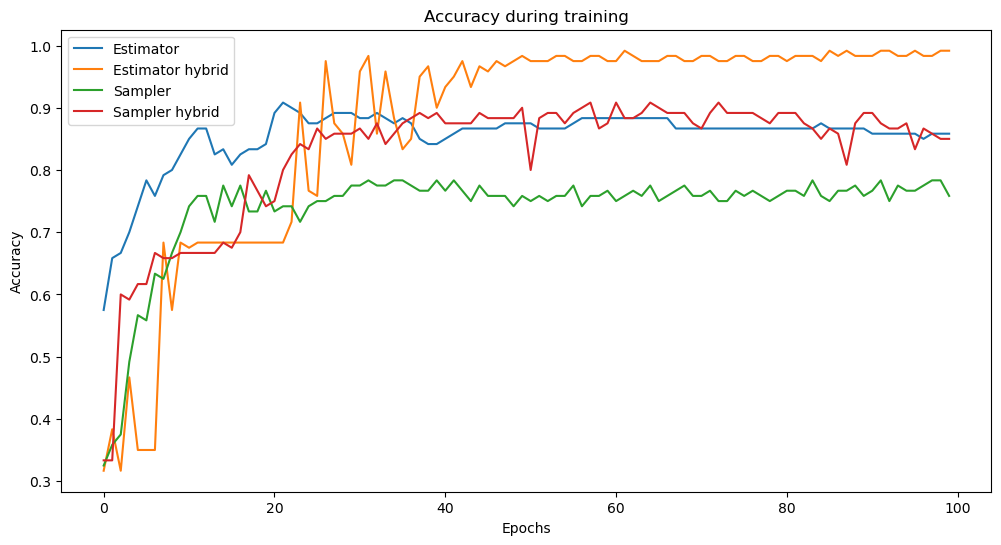

In [24]:
plt.plot(np.arange(len(metrics['acc_train_estimator'])), metrics['acc_train_estimator'], label='Estimator', color='C0')
plt.plot(np.arange(len(metrics['acc_train_estimator_hybrid'])), metrics['acc_train_estimator_hybrid'], label='Estimator hybrid', color='C1')
plt.plot(np.arange(len(metrics['acc_train_sampler'])), metrics['acc_train_sampler'], label='Sampler', color='C2')
plt.plot(np.arange(len(metrics['acc_train_sampler_hybrid'])), metrics['acc_train_sampler_hybrid'], label='Sampler hybrid', color='C3')

plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


From the above graph it is quite clear that a hybrid model does not necessarily perform better than a purely quantum model.

Text(0.5, 0.98, 'Loss')

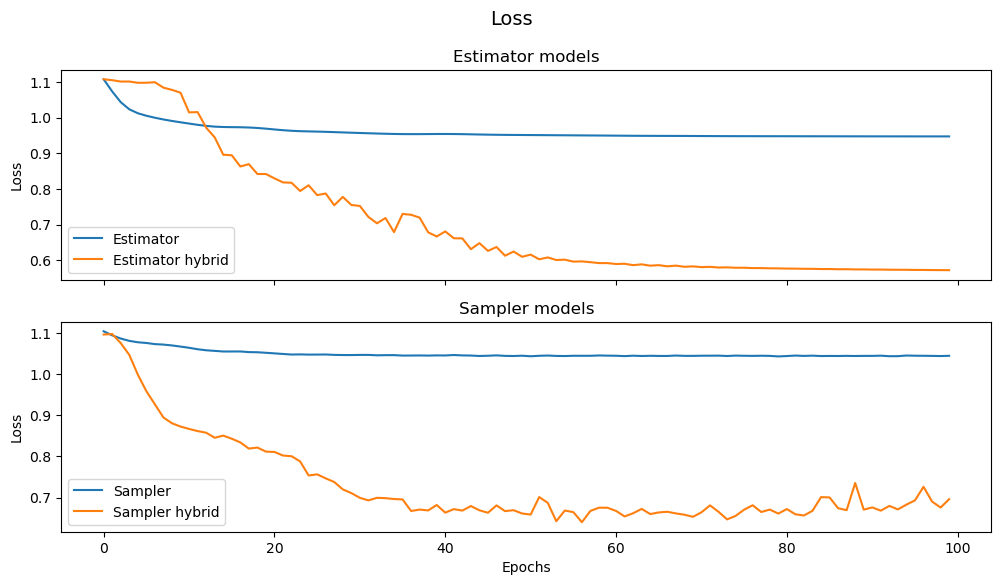

In [25]:
fig, ax = plt.subplots(2, sharex=True)
ax[0].plot(np.arange(len(loss_train_estimator)), loss_train_estimator, label='Estimator')
ax[0].plot(np.arange(len(loss_train_estimator_hybrid)), loss_train_estimator_hybrid, label='Estimator hybrid')
ax[0].legend(loc=3)
ax[0].set_ylabel('Loss')
ax[0].set_title('Estimator models')


ax[1].plot(np.arange(len(loss_train_sampler)), loss_train_sampler, label='Sampler')
ax[1].plot(np.arange(len(loss_train_sampler_hybrid)), loss_train_sampler_hybrid, label='Sampler hybrid')
ax[1].legend(loc=3)
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_title('Sampler models')

plt.suptitle('Loss', fontsize=14)


The loss function during training indicates that most models learn effectively, with the exception of the Estimator model and the Sampler model, which reach a plateau. This suggests that these models may require further investigation, including hyperparameter tuning, to improve their performance and avoid early stagnation.

## Future Work

Future efforts could focus on hyperparameter tuning to optimise model performance. This includes adjusting the number of neurons, selecting the best ansatz and feature maps, and exploring other parameter settings. In addition, an in-depth analysis of computational costs and run-time performance would provide insight into the practical advantages of quantum classifiers compared to classical models, which would help clarify any genuine advantages of quantum systems for classification tasks.